In [1]:
# Only needed to run on AMD CPU
!export MKL_DEBUG_CPU_TYPE=5 

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt

from utility import get_data, plot_images, plot_image_pairs, get_train_val_pair

logging.getLogger().setLevel(logging.INFO)

In [3]:
REFRESH_DATA = False
data = get_data(REFRESH_DATA)

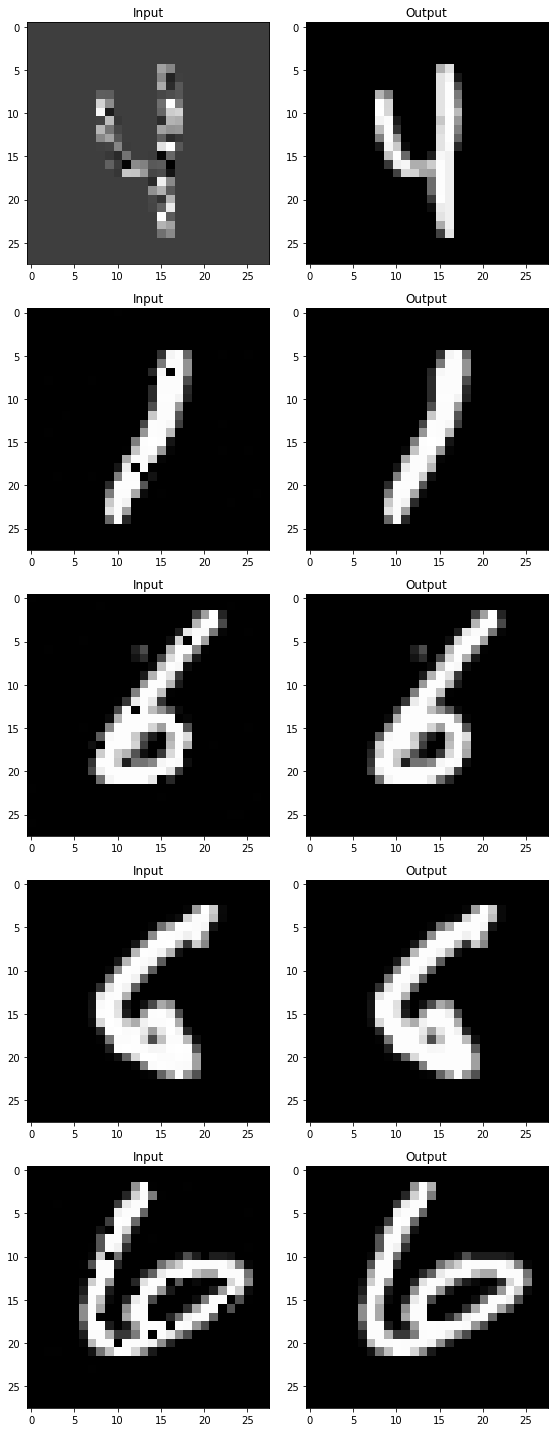

In [4]:
plot_image_pairs(data, ('Input', 'Output'))

In [5]:
(x_train, y_train), (x_val, y_val) = get_train_val_pair(data)
logging.info(f"Total training images: {len(x_train)}")
logging.info(f"Total validation images: {len(x_val)}")

INFO:root:Total training images: 238000
INFO:root:Total validation images: 42000


In [6]:
image_shape = x_train.shape[-2:]
total_pixels = np.prod(image_shape)

In [7]:
inputs = keras.Input(shape=image_shape, name='input_layer')
flatten = keras.layers.Flatten(name='flatten_input_layer')(inputs)
h1 = keras.layers.Dense(512, activation='relu', name='hidden_layer_1') (flatten)
h2 = keras.layers.Dense(256, activation='relu', name='hidden_layer_2') (h1)
h3 = keras.layers.Dense(512, activation='relu', name='hidden_layer_3') (h2)
outputs = keras.layers.Dense(total_pixels, activation='relu', name='output_layer') (h3)
reshape =  keras.layers.Reshape((28,28), name='reshape_output_layer') (outputs)
model = keras.Model(inputs=inputs, outputs=reshape, name = 'MLP')
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='MSE',
    metrics=['accuracy']
)

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               401920    
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 512)               131584    
_________________________________________________________________
output_layer (Dense)         (None, 784)               402192    
_________________________________________________________________
reshape_output_layer (Reshap (None, 28, 28)            0       

In [8]:
!rm -rf ./logs/

In [9]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1
)

earlystop_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-4,
    patience=3
)

history = model.fit(
    x_train, 
    y_train, 
    batch_size = 256,
    epochs=50,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback, earlystop_callback]
)

Train on 190400 samples, validate on 47600 samples
Epoch 1/50
190400/190400 [==============================] - 40s 210us/sample - loss: 0.0168 - accuracy: 0.5238 - val_loss: 0.0119 - val_accuracy: 0.5647
Epoch 2/50
190400/190400 [==============================] - 28s 145us/sample - loss: 0.0107 - accuracy: 0.5704 - val_loss: 0.0101 - val_accuracy: 0.5740
Epoch 3/50
190400/190400 [==============================] - 28s 145us/sample - loss: 0.0095 - accuracy: 0.5802 - val_loss: 0.0092 - val_accuracy: 0.5821
Epoch 4/50
190400/190400 [==============================] - 29s 154us/sample - loss: 0.0086 - accuracy: 0.5864 - val_loss: 0.0087 - val_accuracy: 0.5856
Epoch 5/50
190400/190400 [==============================] - 28s 146us/sample - loss: 0.0083 - accuracy: 0.5907 - val_loss: 0.0084 - val_accuracy: 0.5939
Epoch 6/50
190400/190400 [==============================] - 25s 131us/sample - loss: 0.0080 - accuracy: 0.5937 - val_loss: 0.0084 - val_accuracy: 0.5955
Epoch 7/50
190400/190400 [=====

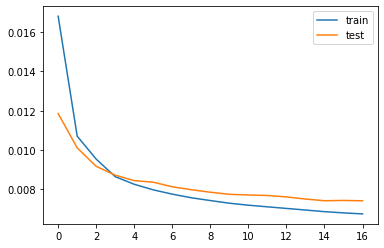

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
model.evaluate(x_val,  y_val, verbose=2)

42000/42000 - 4s - loss: 0.0074 - accuracy: 0.5982


[0.007407778705780705, 0.5981539]

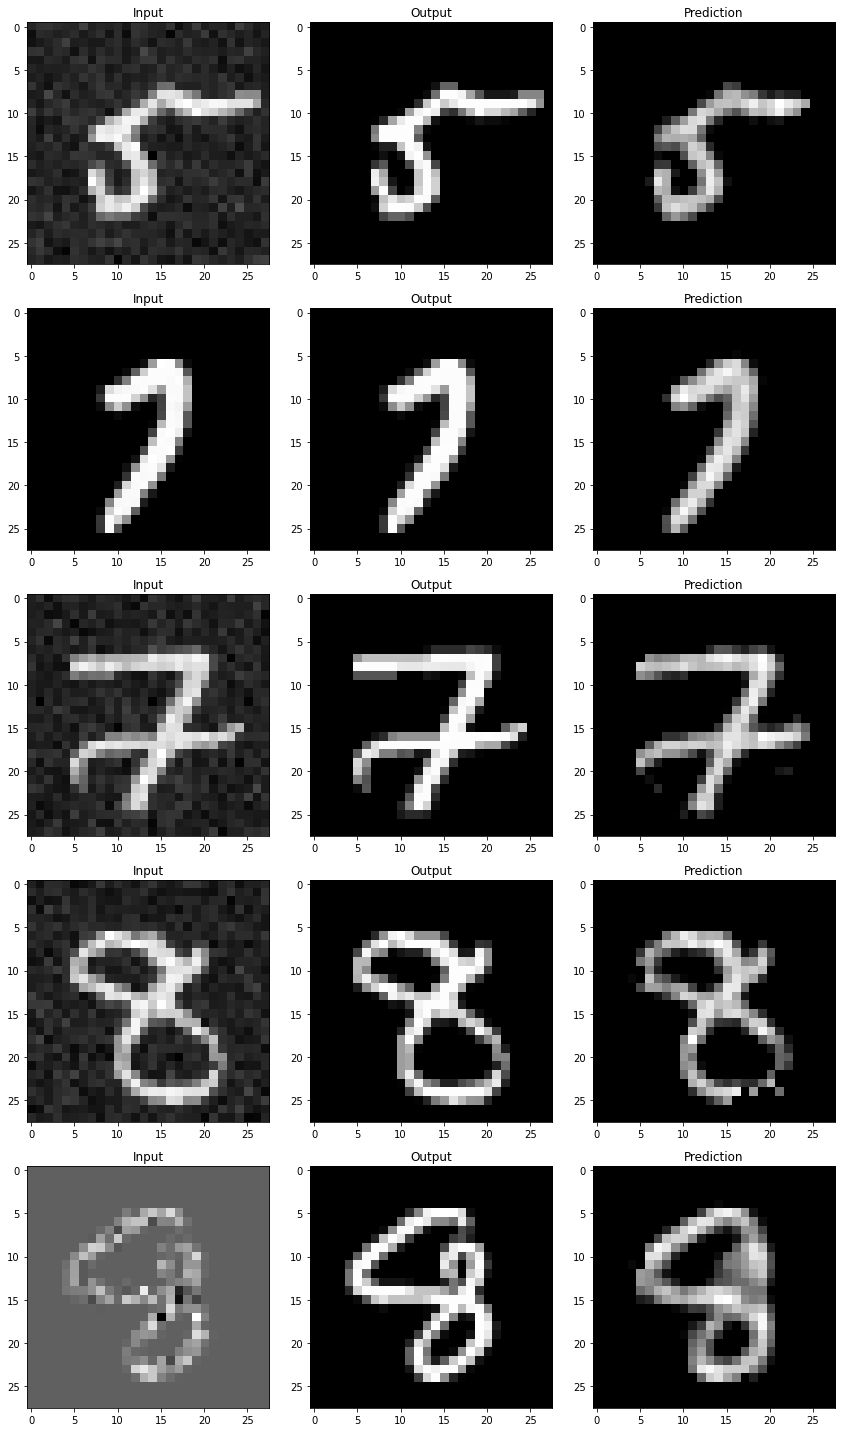

In [12]:
y_val_pred = model.predict(x_val)
plot_image_pairs((x_val, y_val, y_val_pred), ('Input', 'Output','Prediction'))

In [13]:
model.layers[-2].get_weights()[0].shape

(512, 784)

In [14]:
output_layer_weights = model.layers[-2].get_weights()[0]
output_layer_weights = output_layer_weights.reshape(-1, 28, 28)

Output Layer Weights images:


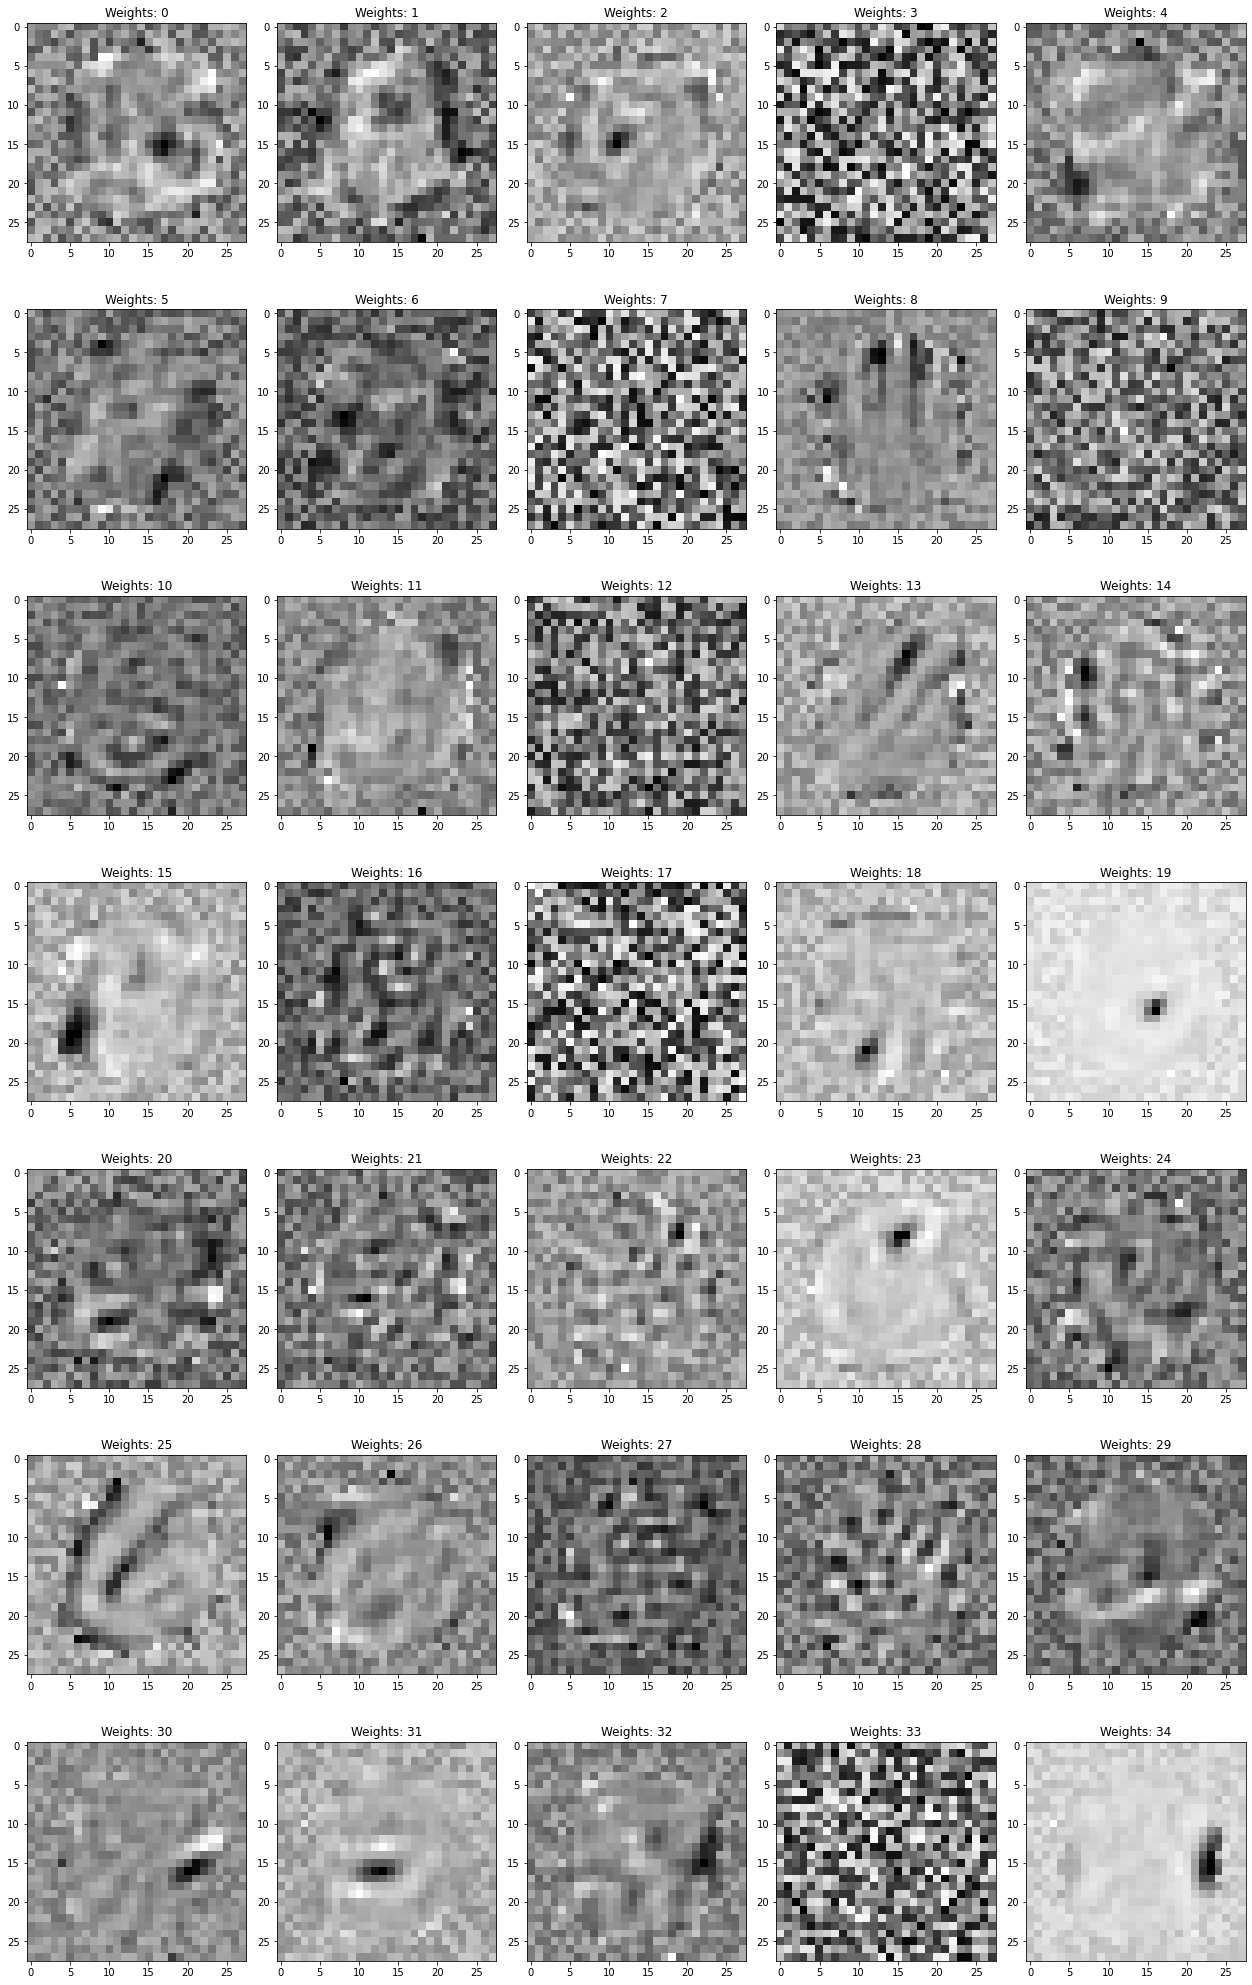

In [15]:
print("Output Layer Weights images:")
plot_images(output_layer_weights)